In [1]:
import numpy as np
import math
from scipy.sparse import coo_matrix
import sys

class Plan:
    
    name = None
    n_beams = None
    n_beamlets = None
    n_voxels = None
    dose_grid_scaling = None
    n_regions = None
    regions = None
    voxel_regions = None
    dose_matrix = None
    fluence_vector = None
    dose_vector = None
    beamlet_coordinates = None

    def __init__(self, config, rois):
        self.parse_config(config)
        self.voxel_regions = np.zeros((self.n_voxels, self.n_regions), dtype='bool')
        self.parse_voxel_rois(rois)
    
    def parse_config(self, config):
        self.name = config[0]
        self.n_beams = int(config[1].split()[0])
        self.n_beamlets = []
        for i in range(2, self.n_beams + 2):
            self.n_beamlets.append((int(config[i].split()[1])))
        self.n_voxels = int(config[self.n_beams + 2].split()[0])
        self.dose_grid_scaling = float(config[self.n_beams + 3].split()[0])
        self.n_regions = int(config[self.n_beams + 4].split()[0])
        self.regions = []
        for i in range(self.n_beams + 5, self.n_beams + self.n_regions + 5):
            line = config[i].split()
            self.regions.insert(int(math.log(int(line[0]), 2)), {'name': ' '.join(line[1:])})
            
    def __str__(self):
        lines = ['Plan summary:']
        lines.append('Name: {}'.format(self.name))
        lines.append('Number of beams: {}'.format(self.n_beams))
        lines.append('Number of beamlets:')
        for i in range(0, len(self.n_beamlets)):
            lines.append('  Beam {}: {} beamlets.'.format(i + 1, self.n_beamlets[i]))
        lines.append('Number of voxels: {}'.format(self.n_voxels))
        lines.append('Dose Grid Scaling: {}'.format(self.dose_grid_scaling))
        lines.append('Number of regions: {}'.format(self.n_regions))
        for i in range(len(self.regions)):
            lines.append('  Region {:2} ({:7}): {:15} {:8} voxels.'.format(
                i, int(math.pow(2, i)), self.regions[i]['name'], self.regions[i]['n_voxels']))
        if self.dose_matrix is None:
            lines.append('No dose deposition matrix')
        else:
            lines.append('Dose deposition matrix: {} x {} with {} nonzeroes.'.format(
                          self.dose_matrix.shape[0], self.dose_matrix.shape[1], self.dose_matrix.nnz))
        if self.fluence_vector is None:
            lines.append('No fluence vector')
        else:
            lines.append('Fluence vector: {} beamlets.'.format(len(self.fluence_vector)))
        if self.dose_vector is None:
            lines.append('No dose vector')
        else:
            lines.append('Dose vector: {} voxels.'.format(len(self.dose_vector)))
        return '\n'.join(lines)

    def int_2_bool_list(self, n):
        return [x == '1' for x in format(n, '0' + str(self.n_regions) + 'b')[::-1]]
    
    def parse_voxel_rois(self, rois):
        i = 0        
        for v in rois:
            self.voxel_regions[i, :] = self.int_2_bool_list(int(v.split()[0]))
            i += 1
            
        for i in range(len(self.regions)):
            self.regions[i]['n_voxels'] = np.sum(self.voxel_regions[:, i])
            
    def compute_dose(self, fluence=None):
        if fluence is None:
            fluence = self.fluence_vector
        self.dose_vector = self.dose_matrix.dot(fluence) * self.dose_grid_scaling
            
        for i in range(len(self.regions)):
            self.regions[i]['doses'] = []
            
        for i in range(len(self.dose_vector)):
            dose = float(self.dose_vector[i])
            for r in range(len(self.regions)):
                #if dose > 0 and self.voxel_regions[i, r]:
                if self.voxel_regions[i, r]:
                    self.regions[r]['doses'].append(dose)

In [2]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse import dok_matrix
import fnmatch
import os
import array
import pickle
import json
from scipy.stats import cumfreq
import matplotlib.pyplot as plt

%matplotlib inline

def dose_percent(dvh, interval, percent):
    return np.argmax(dvh[1] < percent)*interval

def volume_dose(dvh, dose):
    return dvh[1][dvh[0].searchsorted(dose, 'left')]
    
def volume_percent(dvh, dose, percent):
    return volume_dose(dvh, dose*percent/100)

def dose_volume_histogram(doses, bins=1000, max_gy=100):
    interval = max_gy/bins
    hist = np.histogram(doses, bins=bins, range=(0, max_gy))
    n_voxels = len(doses)
    return (hist[1], (n_voxels - np.insert(np.cumsum(hist[0]), 0, 0))*100/n_voxels)    

def dose_ccm(doses, ccm):
    voxels_per_ccm = 64 # Warning, hardcoded!
    idx = min(voxels_per_ccm*ccm, len(doses))
    return sorted(doses)[idx]

funcs = {
    'Min': np.min,
    'Max': np.max,
    'Avg': np.average,
    'Sum': np.sum,
    'STD': np.std,
}

def stats(criteria=None, rids=None):
    lines = [];
    header = "{:20} {:>9} {:>9} {:>9}".format('Region of Interest', 'Min', 'Mean', 'Max')
    lines.append(header)
    lines.append('-'*len(header))
    if rids is None:
        rids = list(range(len(plan.regions)))
    if criteria is not None:
        criteria = criteria['regions']
    for r in rids:
        region = plan.regions[r]
        name = region['name']
        doses = region['doses']
        lines.append("{:20} {:>9.2f} {:>9.2f} {:>9.2f}".format(name, np.min(doses), np.average(doses), np.max(doses)))
    
    if criteria is not None:
        lines.append('')
        for r in rids:
            region = plan.regions[r]
            name = region['name']
            doses = region['doses']
            if name in criteria:
                lines.append(name)
                line = ''
                bins = 1000
                max_gy = 100
                interval = max_gy/bins
                dvh = dose_volume_histogram(doses)
                for c in criteria[name]['criteria']:
                    f = c['f']
                    result = None

                    if f in funcs:
                        result = funcs[f](doses)
                    elif f == 'D{}%':
                        result = dose_percent(dvh, interval, c['value'])
                    elif f == 'V{}Gy':
                        result = volume_dose(dvh, c['value'])
                    elif f == 'V{}%':
                        result = volume_percent(dvh, criteria[name]['dose'], c['value'])
                    elif f == 'D{}ccm':
                        result = dose_ccm(doses, c['value'])

                        
                    if 'value' in c:
                        f = f.format(c['value'])
                    line += '{:>6}'.format(f)
                    
                    if result is None:
                        print('Unknown criteria:', f)
                    else:
                        line += '{:>8.2f} {:2}\n'.format(result, c['unit'])

                lines.append(line)
    
    return lines
    
def plot(filename=None, rids=None):
    #plt.rcParams['figure.figsize'] = [18, 10]
    plt.rcParams['figure.figsize'] = [12, 10]
    plt.rcParams['font.size'] = 18
    bins = 1000
    max_gy = 100
    interval = max_gy/bins
    if rids is None:
        rids = {}
        for i in range(len(plan.regions)):
            rids[i] = None
    for r, color in rids.items():
        region = plan.regions[r]
        hist = np.histogram(region['doses'], bins=bins, range=(0, np.max(region['doses'])))
        #hist = np.histogram(region['doses'], bins=bins, range=(0, max_gy))
        cumsum = (len(region['doses']) - np.insert(np.cumsum(hist[0]), 0, 0))
        cumsum = cumsum*100/len(region['doses'])
        if color is None:
            plt.plot(hist[1], cumsum, linewidth=3, label=region['name'])
        else:
            plt.plot(hist[1], cumsum, linewidth=3, label=region['name'], color=color)
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(loc='upper right')
    plt.grid()
    #plt.title(plan.name)
    plt.ylabel("Volume (%)")
    plt.xlabel("Dose (Grays)")
    plt.xticks(np.arange(0,85,5))
    plt.xlim((-5, 85))
    #plt.xticks(np.arange(0,5*(math.ceil(max_gy/5)+1),5))
    plt.yticks(np.arange(0,85,10))
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
def load_plan(folder):
    files = os.listdir(folder)

    matching = fnmatch.filter(files, 'm_*')
    print("Loading", matching[0], '...')
    with open(os.path.join(folder, matching[0])) as f: 
        config = f.read().splitlines()

    matching = fnmatch.filter(files, 'v_*')
    print("Loading", matching[0], '...')
    with open(os.path.join(folder, matching[0])) as f: 
        voxel_rois = f.read().splitlines()

    plan = Plan(config, voxel_rois)

    rows = array.array('i')
    cols = array.array('i')
    vals = array.array('f')
    col_offset = 0
    beam_index = 0
    matching = fnmatch.filter(files, 'd_*')
    for filename in sorted(matching):
        print("Loading", filename, '...')
        with open(os.path.join(folder, filename)) as f: 
            next(f)
            for line in f:
                line = line.split()
                rows.append(int(line[0]))
                cols.append(int(line[1]) + col_offset)
                vals.append(float(line[2]))
            col_offset += plan.n_beamlets[beam_index]
            beam_index += 1
    plan.dose_matrix = coo_matrix((vals, (rows, cols)), shape=(plan.n_voxels, sum(plan.n_beamlets)), dtype=np.float32).tocsr()

    matching = fnmatch.filter(files, 'x_*')
    fluence = []
    for filename in sorted(matching):
        print("Loading", filename, '...')
        with open(os.path.join(folder, filename)) as f: 
            fluence += [float(x.split()[-1]) for x in f.readlines()]
    plan.fluence_vector = fluence
    
    matching = fnmatch.filter(files, 'xcoords_*')
    plan.beamlet_coordinates = []
    for filename in sorted(matching):
        print("Loading", filename, '... ', end='')
        with open(os.path.join(folder, filename)) as f:
            coords = []
            for line in f.readlines()[12:]:
                line = line.split()
                coords.append((int(line[0]), int(line[1])))
            plan.beamlet_coordinates.append(coords)
            print(len(coords), 'coordinates.')
    
    plan.compute_dose()
    print()
    print(plan)
    return plan

def plot_beam(index, fluence, title, filename=None):
    start = sum(plan.n_beamlets[:index])
    
    beam = np.zeros((120, 120))
    for i in range(plan.n_beamlets[index]):
        x = plan.beamlet_coordinates[index][i][0]
        y = plan.beamlet_coordinates[index][i][1]
        beam[x][y] = fluence[start + i]
    
    plt.style.use("default")
    plt.rcParams['figure.figsize'] = [18, 10]
    plt.rcParams['font.size'] = 18
    plt.matshow(beam, vmin=0, vmax=0.2, cmap='viridis')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.title(title, y=1.2)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

def translate_names(plan):
    translations = {
        'BODY': 'Body',
        'pien mozgu': 'Brainstem',
        'pien mozgu+3mm': 'Brainstem +3mm',
        'rdzen kreg.': 'Spinal cord',
        'rdzen kreg.+3mm': 'Spinal cord +3mm',
        'slinianka L': 'Salivary gland L',
        'slinianka P': 'Salivary gland R',
        'zuchwa': 'Jaw',
        'NT': 'Normal tissue'
    }
    for region in plan.regions:
        if region['name'] in translations:
            region['name'] = translations[region['name']]

def regions_to_plot(plan):
    regions = {
        'Salivary gland L': '#37a134', 
        'Salivary gland R': '#3374b2', 
        'Brainstem +3mm': '#fa7e21', 
        'Spinal cord +3mm': '#38bdcd',
        'Jaw': '#df72c0', 
        'Normal tissue': '#7e7e7e' 
    }
    ptv_colors = ['#d0272f', '#89564d', '#9363bb']
    
    rids = {}
    for r, color in regions.items():
        for i in range(len(plan.regions)):
            name = plan.regions[i]['name']
            if name == r:
                rids[i] = color 
    last_ptv_color = 0
    for r in range(len(plan.regions)):
        name = plan.regions[r]['name']
        #if name in regions:
        #    rids[r] = regions[name]
        if 'PTV' in name:
            rids[r] = ptv_colors[last_ptv_color]
            last_ptv_color += 1
    return rids

def process(folder):
    files = os.listdir(folder)
    matching = fnmatch.filter(files, '*.pkl')
    with open(os.path.join(folder, matching[0]), 'rb') as f:
        fluence = pickle.load(f)

    plan.compute_dose(fluence)
    translate_names(plan)
    rids = regions_to_plot(plan)

    with open('../plans/criteria.json') as f: 
        criteria = json.load(f)

    with open(os.path.join(folder, 'stats.txt'), 'w') as f:
        for line in stats(criteria=criteria, rids=regions_to_plot(plan)):
            f.write(line + '\n')
            print(line)

    plot(filename=os.path.join(folder, 'DVH.pdf'), rids=rids)
    plot(filename=os.path.join(folder, 'DVH.png'), rids=rids)

    for index in range(plan.n_beams):
        plot_beam(index, fluence, 'Beam {}'.format(index + 1), '{}/Beam_{}.png'.format(folder, index + 1))

In [3]:
plan = load_plan('data/Head-and-Neck_02')

Loading m_Head-and-Neck_02.txt ...
Loading v_Head-and-Neck_02.txt ...
Loading d_Head-and-Neck_02.txt ...
Loading x_Head-and-Neck_02.txt ...

Plan summary:
Name: Head-and-Neck_02
Number of beams: 1
Number of beamlets:
  Beam 1: 6331 beamlets.
Number of voxels: 78529
Dose Grid Scaling: 1.0
Number of regions: 21
  Region  0 (      1): Patient            10600 voxels.
  Region  1 (      2): Spinal Cord         3181 voxels.
  Region  2 (      4): Parotid (R)         3315 voxels.
  Region  3 (      8): Parotid (L)         3165 voxels.
  Region  4 (     16): SMG (R)             1487 voxels.
  Region  5 (     32): SMG (L)             1675 voxels.
  Region  6 (     64): MCS                 1621 voxels.
  Region  7 (    128): MCM                  990 voxels.
  Region  8 (    256): MCI                 1257 voxels.
  Region  9 (    512): MCP                 1431 voxels.
  Region 10 (   1024): Oesophagus          1718 voxels.
  Region 11 (   2048): Brainstem           3126 voxels.
  Region 12 (   4

In [13]:
plan.compute_dose()
for line in stats():
    print(line)

Region of Interest         Min      Mean       Max
--------------------------------------------------
Patient                   0.00     23.52     48.30
Spinal Cord               0.00     17.03     28.98
Parotid (R)               0.69     22.73     48.30
Parotid (L)               0.51     20.00     48.30
SMG (R)                  23.29     40.16     48.30
SMG (L)                  18.81     39.00     48.30
MCS                      17.02     37.08     48.14
MCM                      46.53     47.96     48.30
MCI                      39.33     47.62     48.30
MCP                      28.01     41.05     48.00
Oesophagus               20.23     35.10     48.00
Brainstem                 0.00      0.41      7.77
Oral Cavity               1.50     19.70     44.17
Larynx                   40.06     47.64     48.30
PTV 0-46 Gy              42.87     47.50     48.30
PTV Shell 15 mm           2.57     22.97     32.75
PTV Shell 30 mm           0.29     11.60     26.77
PTV Shell 40 mm           0.01 

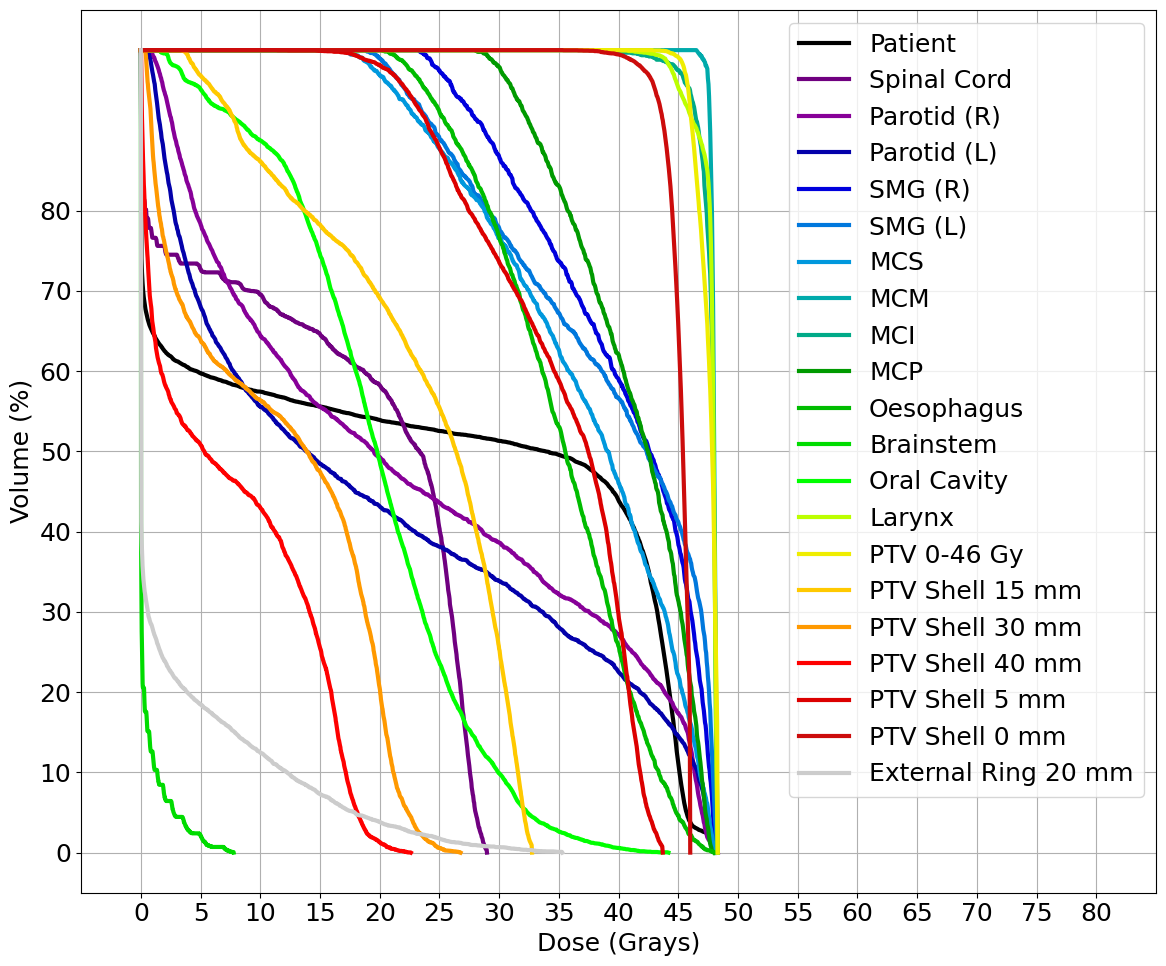

In [14]:
def plot(filename=None, rids=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colormap = plt.cm.nipy_spectral
    colors = colormap(np.linspace(0, 1, len(plan.regions)))
    ax.set_prop_cycle('color', colors)

    #plt.rcParams['figure.figsize'] = [18, 10]
    plt.rcParams['figure.figsize'] = [12, 10]
    plt.rcParams['font.size'] = 18
    bins = 1000
    max_gy = 100
    interval = max_gy/bins
    if rids is None:
        rids = {}
        for i in range(len(plan.regions)):
            rids[i] = None
    for r, color in rids.items():
        region = plan.regions[r]
        hist = np.histogram(region['doses'], bins=bins, range=(0, np.max(region['doses'])))
        #hist = np.histogram(region['doses'], bins=bins, range=(0, max_gy))
        cumsum = (len(region['doses']) - np.insert(np.cumsum(hist[0]), 0, 0))
        cumsum = cumsum*100/len(region['doses'])
        if color is None:
            plt.plot(hist[1], cumsum, linewidth=3, label=region['name'])
        else:
            plt.plot(hist[1], cumsum, linewidth=3, label=region['name'], color=color)
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(loc='upper right')
    plt.grid()
    #plt.title(plan.name)
    plt.ylabel("Volume (%)")
    plt.xlabel("Dose (Grays)")
    plt.xticks(np.arange(0,85,5))
    plt.xlim((-5, 85))
    #plt.xticks(np.arange(0,5*(math.ceil(max_gy/5)+1),5))
    plt.yticks(np.arange(0,85,10))
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

plot()

In [15]:
with open('../gradient/multicore/results/x_20241122_092704.txt') as f: 
    fluence = [float(x.split()[-1]) for x in f.readlines()]

In [16]:
plan.compute_dose(fluence)
for line in stats():
    print(line)

Region of Interest         Min      Mean       Max
--------------------------------------------------
Patient                   0.00     23.23     48.43
Spinal Cord               0.00     11.98     22.75
Parotid (R)               1.64     27.64     47.61
Parotid (L)               0.73     22.44     47.18
SMG (R)                  25.02     38.89     46.39
SMG (L)                  22.00     38.34     46.93
MCS                      29.91     39.40     46.32
MCM                      43.85     44.81     46.17
MCI                      36.37     44.79     46.73
MCP                      29.02     38.36     46.80
Oesophagus               22.74     33.51     46.21
Brainstem                 0.00      0.48      9.54
Oral Cavity               0.95     17.32     42.62
Larynx                   35.99     45.93     47.85
PTV 0-46 Gy              42.61     46.37     48.09
PTV Shell 15 mm           4.23     20.44     33.43
PTV Shell 30 mm           0.43     10.63     25.05
PTV Shell 40 mm           0.01 

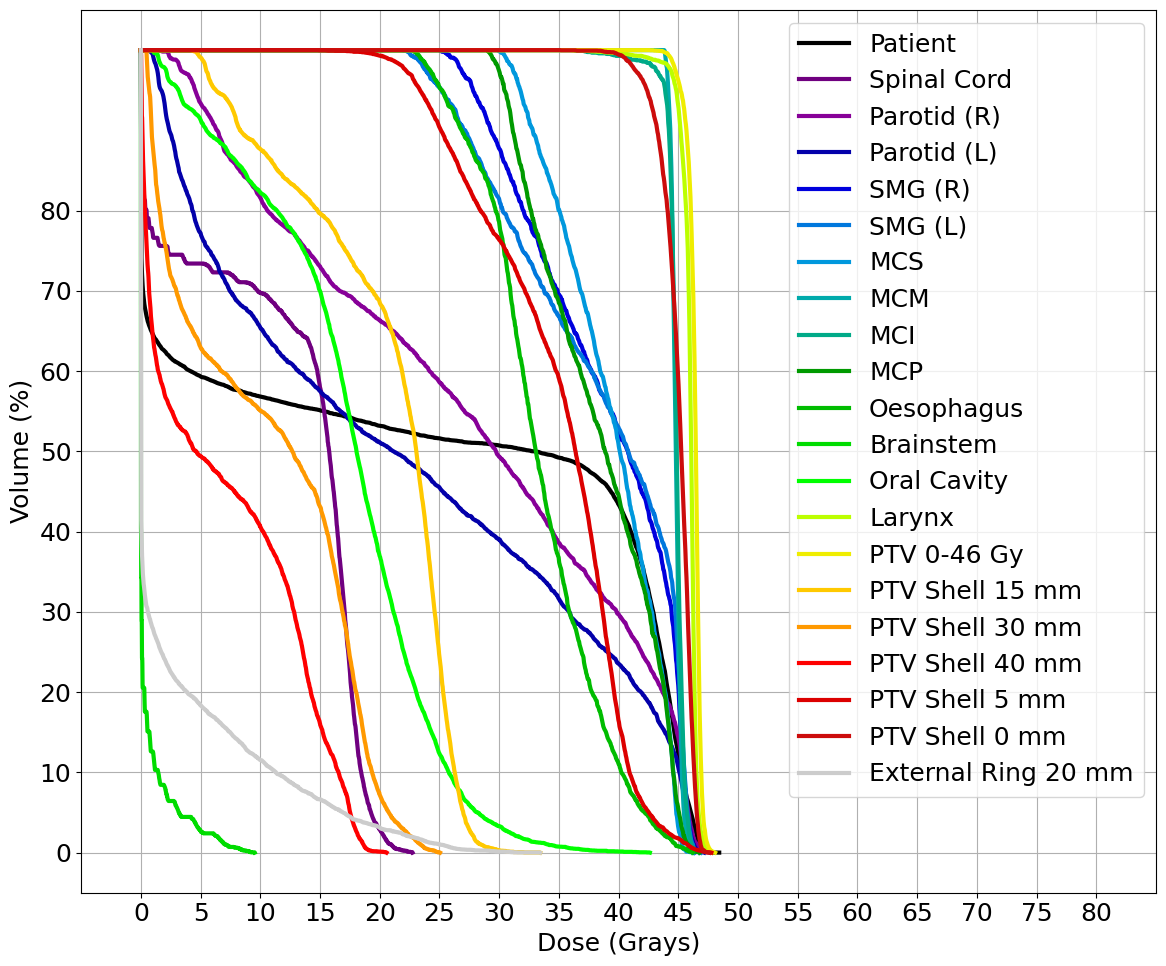

In [17]:
plot()